In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import librosa
import PIL
import tensorflow as tf
import time

In [2]:
# Loading metadata for audio files
metadata = pd.read_csv("UrbanSound8K.csv")
metadata.info()
metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# Droping columns we don't need
metadata = metadata.drop(columns=['fsID', 'start', 'end', 'classID', 'salience', 'fold'])
print(metadata.head())

      slice_file_name             class
0    100032-3-0-0.wav          dog_bark
1  100263-2-0-117.wav  children_playing
2  100263-2-0-121.wav  children_playing
3  100263-2-0-126.wav  children_playing
4  100263-2-0-137.wav  children_playing


# Preprocess images

In [4]:
batch_size = 32
img_width = 80
img_height = 60

# Seed for reproducibility
random_seed = 555
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "spectograms",
    validation_split=0.2,
    subset="training",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    #color_mode = "grayscale"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "spectograms",
    validation_split = 0.2,
    subset = "validation",
    seed = random_seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = True,
    #color_mode = "grayscale"
)

Found 8732 files belonging to 10 classes.
Using 6986 files for training.
Found 8732 files belonging to 10 classes.
Using 1746 files for validation.


['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


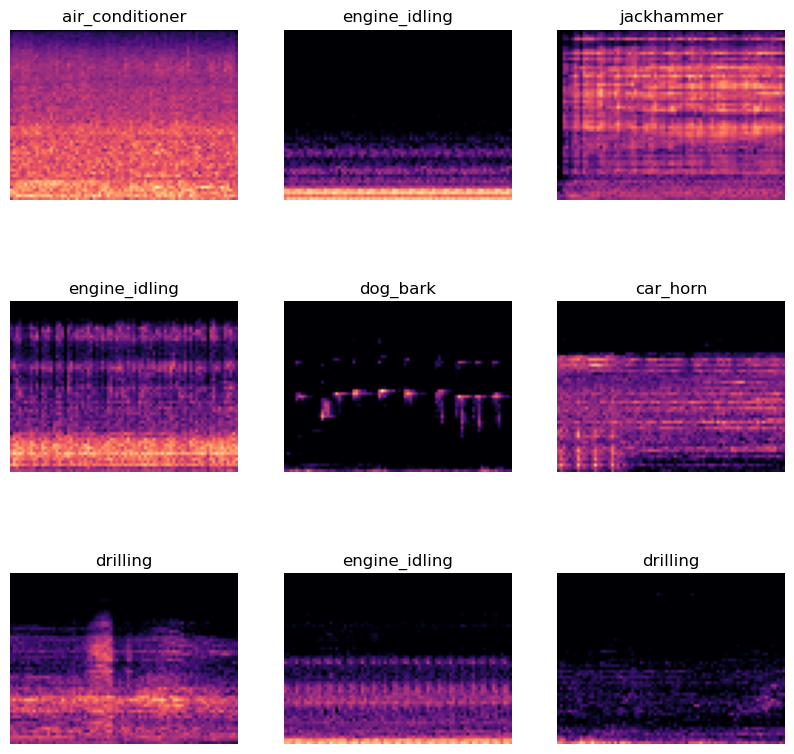

In [6]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Shape of images
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 60, 80, 3)
(32,)


# Build model


In [8]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 80, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 40, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 20, 32)        0

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [11]:
start_time = time.time()

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the training time
print(f"Training time: {elapsed_time:.2f} seconds")

Epoch 1/100
219/219 [==============================] - 79s 277ms/step - loss: 1.8980 - accuracy: 0.3239 - val_loss: 1.7089 - val_accuracy: 0.4782
Epoch 2/100
219/219 [==============================] - 8s 34ms/step - loss: 1.5225 - accuracy: 0.4612 - val_loss: 1.5181 - val_accuracy: 0.5407
Epoch 3/100
219/219 [==============================] - 8s 37ms/step - loss: 1.3776 - accuracy: 0.5206 - val_loss: 1.4466 - val_accuracy: 0.5544
Epoch 4/100
219/219 [==============================] - 8s 37ms/step - loss: 1.2842 - accuracy: 0.5462 - val_loss: 1.3586 - val_accuracy: 0.5813
Epoch 5/100
219/219 [==============================] - 8s 36ms/step - loss: 1.2227 - accuracy: 0.5763 - val_loss: 1.3060 - val_accuracy: 0.5991
Epoch 6/100
219/219 [==============================] - 8s 35ms/step - loss: 1.1644 - accuracy: 0.5948 - val_loss: 1.2610 - val_accuracy: 0.6237
Epoch 7/100
219/219 [==============================] - 8s 37ms/step - loss: 1.1088 - accuracy: 0.6167 - val_loss: 1.2084 - val_accurac

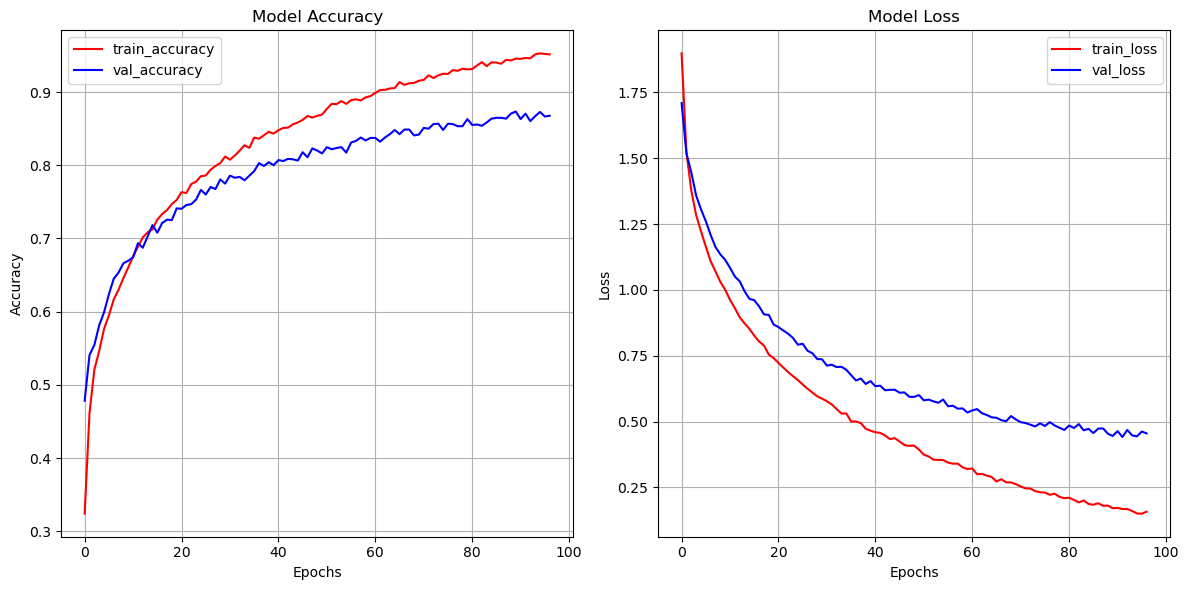

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], color='red', label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Model Accuracy')

# Plot Loss
axes[1].plot(history.history['loss'], color='red', label='train_loss')
axes[1].plot(history.history['val_loss'], color='blue', label='val_loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Model Loss')

fig.tight_layout()
plt.show()

In [13]:
X_test = []
y_test = []
for image, label in val_ds:
    X_test.append(image.numpy())
    y_test.append(label.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

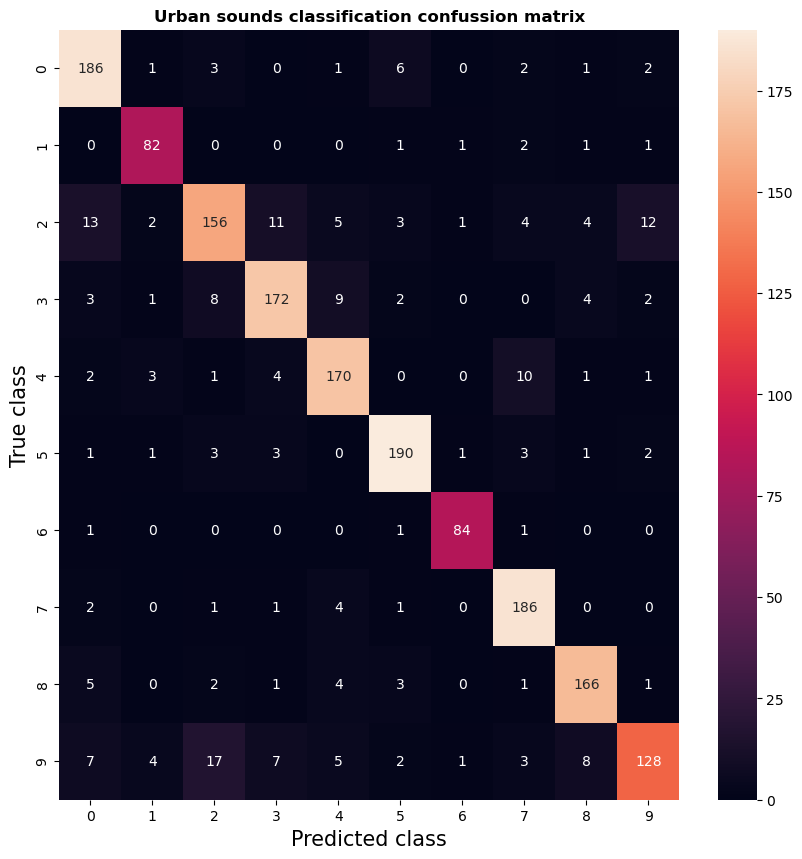

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10, 10))
s = sns.heatmap(cm, annot=True, xticklabels = np.unique(y_test) , yticklabels = np.unique(y_test) , ax = ax, fmt='g')
s.set_xlabel("Predicted class", fontsize = 15)
s.set_ylabel("True class", fontsize = 15)
plt.title("Urban sounds classification confussion matrix", fontweight = "bold")
plt.show()